In [ ]:
from __future__ import absolute_import, division,print_function, unicode_literals

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import GRU

from keras.optimizers import RMSprop

from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import random
import sys


In [ ]:
import urllib.request

# URL of the Shakespeare dataset
url = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

# Download the file
urllib.request.urlretrieve(url, 'shakespeare.txt')

# Open and read the downloaded file
with open('shakespeare.txt', 'r') as file:
    text = file.read()

# A preview of the text file
print(text[:300])  # Displaying the first 300 characters as an example


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


 Creating a mapping from each unique character in the text to a unique number



In [ ]:
# Storing all the unique characters present in the text
vocabulary = sorted(list(set(text)))

# Creating dictionaries to map each character to an index
char_to_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_to_char = dict((i, c) for i, c in enumerate(vocabulary))

print(vocabulary)


['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Pre-processing the data

In [ ]:
# Dividing the text into subsequences of length max_length
# So that at each time step the next max_length characters
# are fed into the network
max_length = 30
steps = 5
sentences = []
next_chars = []
for i in range(0, len(text) - max_length, steps):
	sentences.append(text[i: i + max_length])
	next_chars.append(text[i + max_length])

# Hot encoding each character into a boolean vector

# Initializing a matrix of boolean vectors with each column representing
# the hot encoded representation of the character
X = np.zeros((len(sentences), max_length, len(vocabulary)), dtype = bool)
y = np.zeros((len(sentences), len(vocabulary)), dtype = bool)

# Placing the value 1 at the appropriate position for each vector
# to complete the hot-encoding process
for i, sentence in enumerate(sentences):
	for t, char in enumerate(sentence):
		X[i, t, char_to_indices[char]] = 1
	y[i, char_to_indices[next_chars[i]]] = 1


Building the GRU network

In [ ]:
# Initializing the GRU network
model = Sequential()

# Defining the cell type
model.add(GRU(128, input_shape =(max_length, len(vocabulary))))

# Defining the densely connected Neural Network layer
model.add(Dense(len(vocabulary)))

# Defining the activation function for the cell
model.add(Activation('softmax'))

# Defining the optimizing function
optimizer = RMSprop(lr = 0.01)

# Configuring the model for training
model.compile(loss ='categorical_crossentropy', optimizer = optimizer)


a) Helper function to sample the next character:



In [ ]:
# Helper function to sample an index from a probability array
def sample_index(preds, temperature = 1.0):
# temperature determines the freedom the function has when generating text

	# Converting the predictions vector into a numpy array
	preds = np.asarray(preds).astype('float64')

	# Normalizing the predictions array
	preds = np.log(preds) / temperature
	exp_preds = np.exp(preds)
	preds = exp_preds / np.sum(exp_preds)

	# The main sampling step. Creates an array of probabilities signifying
	# the probability of each character to be the next character in the
	# generated text
	probas = np.random.multinomial(1, preds, 1)

	# Returning the character with maximum probability to be the next character
	# in the generated text
	return np.argmax(probas)


b) Helper function to generate text after each epoch



In [ ]:
# Helper function to generate text after the end of each epoch
def on_epoch_end(epoch, logs):
	print()
	print('----- Generating text after Epoch: % d' % epoch)

	# Choosing a random starting index for the text generation
	start_index = random.randint(0, len(text) - max_length - 1)

	# Sampling for different values of diversity
	for diversity in [0.2, 0.5, 1.0, 1.2]:
		print('----- diversity:', diversity)

		generated = ''

		# Seed sentence
		sentence = text[start_index: start_index + max_length]

		generated += sentence
		print('----- Generating with seed: "' + sentence + '"')
		sys.stdout.write(generated)

		for i in range(400):
			# Initializing the predictions vector
			x_pred = np.zeros((1, max_length, len(vocabulary)))

			for t, char in enumerate(sentence):
				x_pred[0, t, char_to_indices[char]] = 1.

			# Making the predictions for the next character
			preds = model.predict(x_pred, verbose = 0)[0]

			# Getting the index of the most probable next character
			next_index = sample_index(preds, diversity)

			# Getting the most probable next character using the mapping built
			next_char = indices_to_char[next_index]

			# Building the generated text
			generated += next_char
			sentence = sentence[1:] + next_char

			sys.stdout.write(next_char)
			sys.stdout.flush()
		print()

# Defining a custom callback function to
# describe the internal states of the network
print_callback = LambdaCallback(on_epoch_end = on_epoch_end)


c) Helper function to save the model after each epoch in which loss decreases



In [ ]:
# Defining a helper function to save the model after each epoch
# in which the loss decreases
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor ='loss',
							verbose = 1, save_best_only = True,
							mode ='min')


d) Helper function to reduce the learning rate each time the learning plateaus



In [ ]:
# Defining a helper function to reduce the learning rate each time
# the learning plateaus
reduce_alpha = ReduceLROnPlateau(monitor ='loss', factor = 0.2,
							patience = 1, min_lr = 0.001)
callbacks = [print_callback, checkpoint, reduce_alpha]


Training the GRU model



In [ ]:
# Training the GRU model
# model.fit(X, y, batch_size = 256, epochs = 10, callbacks = callbacks)


Generating new and random text

In [ ]:
# def generate_text(length, diversity):
# 	# Get random starting text
# 	start_index = random.randint(0, len(text) - max_length - 1)

# 	# Defining the generated text
# 	generated = ''
# 	sentence = text[start_index: start_index + max_length]
# 	generated += sentence

# 	# Generating new text of given length
# 	for i in range(length):

# 			# Initializing the prediction vector
# 			x_pred = np.zeros((1, max_length, len(vocabulary)))
# 			for t, char in enumerate(sentence):
# 				x_pred[0, t, char_to_indices[char]] = 1.

# 			# Making the predictions
# 			preds = model.predict(x_pred, verbose = 0)[0]

# 			# Getting the index of the next most probable index
# 			next_index = sample_index(preds, diversity)

# 			# Getting the most probable next character using the mapping built
# 			next_char = indices_to_char[next_index]

# 			# Generating new text
# 			generated += next_char
# 			sentence = sentence[1:] + next_char
# 	return generated

# print(generate_text(500, 1.0))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               74880     
                                                                 
 dense (Dense)               (None, 65)                8385      
                                                                 
 activation (Activation)     (None, 65)                0         
                                                                 
Total params: 83265 (325.25 KB)
Trainable params: 83265 (325.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model and capture the training history
# history = model.fit(X, y, batch_size=200, epochs=20)

# # Print the final accuracy
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")


Epoch 1/20
1116/1116 [==============================] - 8s 5ms/step - loss: 2.4778 - accuracy: 0.3141
Epoch 2/20
1116/1116 [==============================] - 6s 5ms/step - loss: 2.0609 - accuracy: 0.4031
Epoch 3/20
1116/1116 [==============================] - 8s 7ms/step - loss: 1.9059 - accuracy: 0.4407
Epoch 4/20
1116/1116 [==============================] - 7s 6ms/step - loss: 1.8038 - accuracy: 0.4678
Epoch 5/20
1116/1116 [==============================] - 5s 5ms/step - loss: 1.7322 - accuracy: 0.4881
Epoch 6/20
1116/1116 [==============================] - 6s 5ms/step - loss: 1.6794 - accuracy: 0.5006
Epoch 7/20
1116/1116 [==============================] - 5s 5ms/step - loss: 1.6373 - accuracy: 0.5122
Epoch 8/20
1116/1116 [==============================] - 6s 6ms/step - loss: 1.6031 - accuracy: 0.5213
Epoch 9/20
1116/1116 [==============================] - 5s 5ms/step - loss: 1.5741 - accuracy: 0.5289
Epoch 10/20
1116/1116 [==============================] - 5s 5ms/step - loss: 1.548

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
# Train the model and capture the training history
# history = model.fit(X, y, batch_size=256, epochs=20)

Epoch 1/20
872/872 [==============================] - 7s 5ms/step - loss: 1.3827 - accuracy: 0.5799
Epoch 2/20
872/872 [==============================] - 5s 5ms/step - loss: 1.3734 - accuracy: 0.5820
Epoch 3/20
872/872 [==============================] - 4s 5ms/step - loss: 1.3651 - accuracy: 0.5841
Epoch 4/20
872/872 [==============================] - 4s 5ms/step - loss: 1.3580 - accuracy: 0.5862
Epoch 5/20
872/872 [==============================] - 5s 6ms/step - loss: 1.3502 - accuracy: 0.5885
Epoch 6/20
872/872 [==============================] - 4s 5ms/step - loss: 1.3430 - accuracy: 0.5902
Epoch 7/20
872/872 [==============================] - 4s 5ms/step - loss: 1.3360 - accuracy: 0.5920
Epoch 8/20
872/872 [==============================] - 5s 5ms/step - loss: 1.3283 - accuracy: 0.5938
Epoch 9/20
872/872 [==============================] - 4s 5ms/step - loss: 1.3228 - accuracy: 0.5958
Epoch 10/20
872/872 [==============================] - 4s 5ms/step - loss: 1.3160 - accuracy: 0.5973

In [ ]:
# Print the final accuracy
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")

Final Training Accuracy: 61.13%


In [ ]:
# history = model.fit(X, y, batch_size=512, epochs=20)

Epoch 1/20
436/436 [==============================] - 3s 8ms/step - loss: 1.2309 - accuracy: 0.6221
Epoch 2/20
436/436 [==============================] - 3s 6ms/step - loss: 1.2261 - accuracy: 0.6238
Epoch 3/20
436/436 [==============================] - 3s 6ms/step - loss: 1.2249 - accuracy: 0.6241
Epoch 4/20
436/436 [==============================] - 3s 6ms/step - loss: 1.2239 - accuracy: 0.6244
Epoch 5/20
436/436 [==============================] - 3s 7ms/step - loss: 1.2212 - accuracy: 0.6247
Epoch 6/20
436/436 [==============================] - 3s 7ms/step - loss: 1.2198 - accuracy: 0.6249
Epoch 7/20
436/436 [==============================] - 3s 6ms/step - loss: 1.2166 - accuracy: 0.6258
Epoch 8/20
436/436 [==============================] - 3s 6ms/step - loss: 1.2140 - accuracy: 0.6262
Epoch 9/20
436/436 [==============================] - 3s 7ms/step - loss: 1.2106 - accuracy: 0.6274
Epoch 10/20
436/436 [==============================] - 3s 7ms/step - loss: 1.2075 - accuracy: 0.6286

In [ ]:
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")

Final Training Accuracy: 63.68%


In [ ]:
# history = model.fit(X, y, batch_size=512, epochs=20)

Epoch 1/20
436/436 [==============================] - 3s 7ms/step - loss: 1.1314 - accuracy: 0.6507
Epoch 2/20
436/436 [==============================] - 3s 7ms/step - loss: 1.1163 - accuracy: 0.6555
Epoch 3/20
436/436 [==============================] - 3s 6ms/step - loss: 1.1177 - accuracy: 0.6551
Epoch 4/20
436/436 [==============================] - 3s 7ms/step - loss: 1.1190 - accuracy: 0.6538
Epoch 5/20
436/436 [==============================] - 3s 7ms/step - loss: 1.1190 - accuracy: 0.6540
Epoch 6/20
436/436 [==============================] - 3s 6ms/step - loss: 1.1247 - accuracy: 0.6520
Epoch 7/20
436/436 [==============================] - 3s 6ms/step - loss: 1.1191 - accuracy: 0.6537
Epoch 8/20
436/436 [==============================] - 3s 7ms/step - loss: 1.1187 - accuracy: 0.6539
Epoch 9/20
436/436 [==============================] - 3s 8ms/step - loss: 1.1178 - accuracy: 0.6541
Epoch 10/20
436/436 [==============================] - 3s 7ms/step - loss: 1.1168 - accuracy: 0.6540

In [ ]:
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")

Final Training Accuracy: 65.80%


In [ ]:
# history = model.fit(X, y, batch_size=512, epochs=40)

Epoch 1/40
436/436 [==============================] - 3s 8ms/step - loss: 1.1040 - accuracy: 0.6582
Epoch 2/40
436/436 [==============================] - 3s 6ms/step - loss: 1.1038 - accuracy: 0.6590
Epoch 3/40
436/436 [==============================] - 3s 6ms/step - loss: 1.1020 - accuracy: 0.6584
Epoch 4/40
436/436 [==============================] - 3s 6ms/step - loss: 1.1029 - accuracy: 0.6574
Epoch 5/40
436/436 [==============================] - 3s 7ms/step - loss: 1.1012 - accuracy: 0.6579
Epoch 6/40
436/436 [==============================] - 3s 7ms/step - loss: 1.1016 - accuracy: 0.6578
Epoch 7/40
436/436 [==============================] - 3s 6ms/step - loss: 1.1000 - accuracy: 0.6585
Epoch 8/40
436/436 [==============================] - 3s 6ms/step - loss: 1.0998 - accuracy: 0.6593
Epoch 9/40
436/436 [==============================] - 3s 7ms/step - loss: 1.1001 - accuracy: 0.6589
Epoch 10/40
436/436 [==============================] - 3s 7ms/step - loss: 1.0980 - accuracy: 0.6597

In [ ]:
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")

Final Training Accuracy: 66.21%


In [ ]:
# history = model.fit(X, y, batch_size=1024, epochs=20)

Epoch 1/20
218/218 [==============================] - 3s 12ms/step - loss: 1.1022 - accuracy: 0.6568
Epoch 2/20
218/218 [==============================] - 2s 11ms/step - loss: 1.0606 - accuracy: 0.6715
Epoch 3/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0421 - accuracy: 0.6779
Epoch 4/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0322 - accuracy: 0.6809
Epoch 5/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0268 - accuracy: 0.6837
Epoch 6/20
218/218 [==============================] - 2s 11ms/step - loss: 1.0240 - accuracy: 0.6843
Epoch 7/20
218/218 [==============================] - 2s 11ms/step - loss: 1.0226 - accuracy: 0.6843
Epoch 8/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0227 - accuracy: 0.6848
Epoch 9/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0235 - accuracy: 0.6837
Epoch 10/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0258 - accura

In [ ]:
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")

Final Training Accuracy: 68.09%


In [ ]:
# history = model.fit(X, y, batch_size=1024, epochs=20)

Epoch 1/20
218/218 [==============================] - 2s 11ms/step - loss: 1.0255 - accuracy: 0.6820
Epoch 2/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0261 - accuracy: 0.6824
Epoch 3/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0288 - accuracy: 0.6814
Epoch 4/20
218/218 [==============================] - 2s 11ms/step - loss: 1.0283 - accuracy: 0.6814
Epoch 5/20
218/218 [==============================] - 2s 11ms/step - loss: 1.0269 - accuracy: 0.6815
Epoch 6/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0265 - accuracy: 0.6817
Epoch 7/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0243 - accuracy: 0.6830
Epoch 8/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0232 - accuracy: 0.6831
Epoch 9/20
218/218 [==============================] - 2s 10ms/step - loss: 1.0233 - accuracy: 0.6829
Epoch 10/20
218/218 [==============================] - 2s 11ms/step - loss: 1.0220 - accura

In [ ]:
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")

Final Training Accuracy: 68.45%


In [ ]:
# history = model.fit(X, y, batch_size=1024, epochs=50)

Epoch 1/50
218/218 [==============================] - 2s 11ms/step - loss: 1.0168 - accuracy: 0.6851
Epoch 2/50
218/218 [==============================] - 3s 12ms/step - loss: 1.0250 - accuracy: 0.6816
Epoch 3/50
218/218 [==============================] - 2s 11ms/step - loss: 1.0194 - accuracy: 0.6840
Epoch 4/50
218/218 [==============================] - 2s 10ms/step - loss: 1.0215 - accuracy: 0.6841
Epoch 5/50
218/218 [==============================] - 2s 10ms/step - loss: 1.0185 - accuracy: 0.6839
Epoch 6/50
218/218 [==============================] - 2s 10ms/step - loss: 1.0218 - accuracy: 0.6828
Epoch 7/50
218/218 [==============================] - 2s 11ms/step - loss: 1.0154 - accuracy: 0.6853
Epoch 8/50
218/218 [==============================] - 2s 11ms/step - loss: 1.0140 - accuracy: 0.6857
Epoch 9/50
218/218 [==============================] - 2s 10ms/step - loss: 1.0162 - accuracy: 0.6850
Epoch 10/50
218/218 [==============================] - 2s 10ms/step - loss: 1.0165 - accura

In [ ]:
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")

Final Training Accuracy: 68.81%


In [ ]:
# history = model.fit(X, y, batch_size=128, epochs=20)

Epoch 1/20
1743/1743 [==============================] - 8s 5ms/step - loss: 1.3594 - accuracy: 0.5857
Epoch 2/20
1743/1743 [==============================] - 9s 5ms/step - loss: 1.2766 - accuracy: 0.6050
Epoch 3/20
1743/1743 [==============================] - 9s 5ms/step - loss: 1.2536 - accuracy: 0.6109
Epoch 4/20
1743/1743 [==============================] - 8s 5ms/step - loss: 1.2465 - accuracy: 0.6126
Epoch 5/20
1743/1743 [==============================] - 9s 5ms/step - loss: 1.2286 - accuracy: 0.6183
Epoch 6/20
1743/1743 [==============================] - 9s 5ms/step - loss: 1.2241 - accuracy: 0.6181
Epoch 7/20
1743/1743 [==============================] - 8s 5ms/step - loss: 1.2218 - accuracy: 0.6192
Epoch 8/20
1743/1743 [==============================] - 9s 5ms/step - loss: 1.2168 - accuracy: 0.6208
Epoch 9/20
1743/1743 [==============================] - 9s 5ms/step - loss: 1.2133 - accuracy: 0.6220
Epoch 10/20
1743/1743 [==============================] - 8s 5ms/step - loss: 1.212

In [ ]:
# final_accuracy = history.history['accuracy'][-1]
# print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")

Final Training Accuracy: 62.54%


In [ ]:
history = model.fit(X, y, epochs=20, batch_size=512, callbacks=[checkpoint, early_stopping])

# Access validation loss and accuracy from the history object
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Print the validation loss and accuracy
print(f'Validation Loss: {val_loss[-1]}')
print(f'Validation Accuracy: {val_accuracy[-1]}')

Epoch 1/20
434/436 [============================>.] - ETA: 0s - loss: 1.1356 - accuracy: 0.6461

436/436 [==============================] - 5s 7ms/step - loss: 1.1358 - accuracy: 0.6460
Epoch 2/20
431/436 [============================>.] - ETA: 0s - loss: 1.1154 - accuracy: 0.6529

436/436 [==============================] - 3s 7ms/step - loss: 1.1148 - accuracy: 0.6531
Epoch 3/20
434/436 [============================>.] - ETA: 0s - loss: 1.1085 - accuracy: 0.6552

436/436 [==============================] - 3s 6ms/step - loss: 1.1087 - accuracy: 0.6552
Epoch 4/20
436/436 [==============================] - ETA: 0s - loss: 1.1033 - accuracy: 0.6566

436/436 [==============================] - 3s 7ms/step - loss: 1.1033 - accuracy: 0.6566
Epoch 5/20
431/436 [============================>.] - ETA: 0s - loss: 1.1012 - accuracy: 0.6574

436/436 [==============================] - 3s 7ms/step - loss: 1.1009 - accuracy: 0.6576
Epoch 6/20
435/436 [============================>.] - ETA: 0s - loss: 1.0959 - accuracy: 0.6585

436/436 [==============================] - 3s 8ms/step - loss: 1.0959 - accuracy: 0.6585
Epoch 7/20
429/436 [============================>.] - ETA: 0s - loss: 1.0935 - accuracy: 0.6592

436/436 [==============================] - 3s 7ms/step - loss: 1.0935 - accuracy: 0.6591
Epoch 8/20
430/436 [============================>.] - ETA: 0s - loss: 1.0941 - accuracy: 0.6597

436/436 [==============================] - 3s 7ms/step - loss: 1.0938 - accuracy: 0.6598
Epoch 9/20
435/436 [============================>.] - ETA: 0s - loss: 1.0882 - accuracy: 0.6613

436/436 [==============================] - 3s 7ms/step - loss: 1.0881 - accuracy: 0.6613
Epoch 10/20
435/436 [============================>.] - ETA: 0s - loss: 1.0861 - accuracy: 0.6625

436/436 [==============================] - 3s 7ms/step - loss: 1.0862 - accuracy: 0.6624
Epoch 11/20
434/436 [============================>.] - ETA: 0s - loss: 1.0846 - accuracy: 0.6615

436/436 [==============================] - 3s 7ms/step - loss: 1.0846 - accuracy: 0.6615
Epoch 12/20
430/436 [============================>.] - ETA: 0s - loss: 1.0829 - accuracy: 0.6626

436/436 [==============================] - 3s 7ms/step - loss: 1.0833 - accuracy: 0.6624
Epoch 13/20
431/436 [============================>.] - ETA: 0s - loss: 1.0817 - accuracy: 0.6629

436/436 [==============================] - 3s 7ms/step - loss: 1.0820 - accuracy: 0.6628
Epoch 14/20
433/436 [============================>.] - ETA: 0s - loss: 1.0797 - accuracy: 0.6637

436/436 [==============================] - 3s 7ms/step - loss: 1.0797 - accuracy: 0.6636
Epoch 15/20
433/436 [============================>.] - ETA: 0s - loss: 1.0786 - accuracy: 0.6643

436/436 [==============================] - 3s 7ms/step - loss: 1.0790 - accuracy: 0.6642
Epoch 16/20
429/436 [============================>.] - ETA: 0s - loss: 1.0779 - accuracy: 0.6636

436/436 [==============================] - 3s 7ms/step - loss: 1.0781 - accuracy: 0.6636
Epoch 17/20
430/436 [============================>.] - ETA: 0s - loss: 1.0746 - accuracy: 0.6642

436/436 [==============================] - 3s 7ms/step - loss: 1.0749 - accuracy: 0.6641
Epoch 18/20
430/436 [============================>.] - ETA: 0s - loss: 1.0751 - accuracy: 0.6647

436/436 [==============================] - 3s 7ms/step - loss: 1.0752 - accuracy: 0.6646
Epoch 19/20
432/436 [============================>.] - ETA: 0s - loss: 1.0722 - accuracy: 0.6653

436/436 [==============================] - 3s 7ms/step - loss: 1.0723 - accuracy: 0.6653
Epoch 20/20
431/436 [============================>.] - ETA: 0s - loss: 1.0720 - accuracy: 0.6655

436/436 [==============================] - 3s 7ms/step - loss: 1.0722 - accuracy: 0.6654


KeyError: ignored

In [ ]:
final_loss = history.history['loss'][-1]

# Calculate perplexity
perplexity = np.exp(final_loss)

# Print the perplexity
print(f"Final Perplexity: {perplexity:.2f}")

Final Perplexity: 4.05


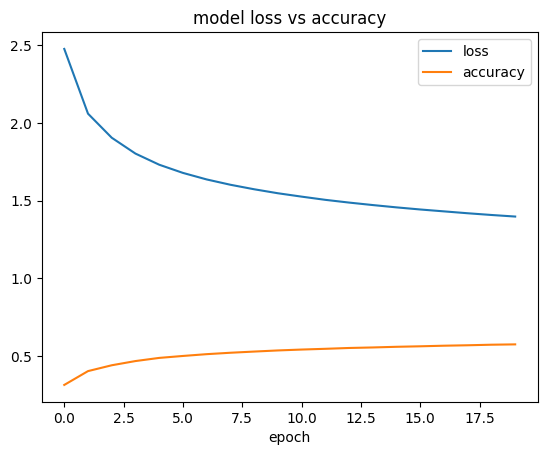

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
model.fit(X, y, batch_size=256, epochs=20, validation_split=0.2, callbacks=callbacks)


In [ ]:
def generate_text(length, diversity):
	# Get random starting text
	start_index = random.randint(0, len(text) - max_length - 1)

	# Defining the generated text
	generated = ''
	sentence = text[start_index: start_index + max_length]
	generated += sentence

	# Generating new text of given length
	for i in range(length):

			# Initializing the prediction vector
			x_pred = np.zeros((1, max_length, len(vocabulary)))
			for t, char in enumerate(sentence):
				x_pred[0, t, char_to_indices[char]] = 1.

			# Making the predictions
			preds = model.predict(x_pred, verbose = 0)[0]

			# Getting the index of the next most probable index
			next_index = sample_index(preds, diversity)

			# Getting the most probable next character using the mapping built
			next_char = indices_to_char[next_index]

			# Generating new text
			generated += next_char
			sentence = sentence[1:] + next_char
	return generated

print(generate_text(500, 1.0))


so far free him--made him fear for thy's queen
To her I spay traitor's lay then
I look my sportion's partent. Let usel,
Come to his rease. O, that by our coisonseld
Titure with rispabus, Son
See thyig time? Why hame than the percot.
Where of my do.

MAMANkTHENVY:
I'll brow her trines in his a fair out his sport,
Unship and disfordiniby, love he is geter stull
Well, not, why less in prise, enemanted,
And son by a happoners since to with me and then:
What ack, Petestigns or sometime and verys most straze?

ISABELLA:
Why, curce
